## Notebook d'aide pour les conditions limites simples sur flopy (CHD, WEL, RIV, ...)

Ce notebook a pour but de présenter comment créer les différents packages de conditions limites simples que peut offrir flopy et Modflow 6.
Les packages abordés sont les suivants :
- CHD (charges constantes)
- WEL (limite de type Neumann à flux imposé, puits, sources, ...)
- RCH (package de recharge)
- GHB, RIV, DRN, ... (packages en limites type Cauchy pour divers trucs)

In [1]:
import numpy as np
import flopy as fp
import matplotlib.pyplot as plt
import os
import sys

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
# some functions
def get_heads(model_name,workspace):
    """
    Function that returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    return head

def get_spdis(model_name,workspace):
    """
    Function that returns the specific discharge from the cbcfile
    """
    
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    spdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = spdobj.get_data(text="SPDIS")
    
    return spd

#### On va d'abord définir les paramètres spatiaux du modèle¶

In [3]:
res_x = 4 # la résolution en x
res_y = 5 # idem en y
ncol = 40 # le nombre de colonne
nrow = 30 # le nombre de lignes
nlay = 3 # le nombre de couches

delr = np.ones(ncol)*res_x # le vecteur contenant les espacements en x (direction des lignes)
delc = np.ones(nrow)*res_y # le vecteur contenant les espacements en y (direction des colonnes)
a = np.ones([nrow])
top = (a[:,np.newaxis]*np.linspace(10,8,ncol)) # altitude du top du modèle (petit trick pour faire un top descendant de 10 m à gauche  à 8 m à droite)
botm = [5,0,-1]

idomain = 1 # idomain (tout actif)

### On est bon alors commencons par faire les packages essentiels


In [4]:
# VERY basic modules
model_name="tuto_BC"
model_dir = "workspace"
exe_name = "../../exe/mf6.exe"

#SIM essentiel à tout modèle mf6, c'est lui qui contient tous les packages et infos
sim = fp.mf6.MFSimulation(sim_name='tuto_BC', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)

# GWF --> le modèle d'écoulement auquel seront rattachés les différents packages
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

# DIS --> Discrétisation spatiale
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,idomain=idomain)

# TDIS --> discrétisation temporelle
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])

# IMS --> solver (simple on s'embête pas)
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# IC --> initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=1)

# OC --> output control (fichiers de sortie)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),# nom du fichier budget (ne pas changer)
                            head_filerecord='{}.hds'.format(model_name),# nom du fichier des charges (ne pas changer)
                            saverecord=[('HEAD', 'LAST'), 
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty (conductivité, flux à enregistrer, type de cellule ...)
k = [1e-4,1e-6,1e-4] # perméabilité des couches, par couche
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True,save_specific_discharge=True)

### Maintenant tout est prêt pour faire nos différents packages

## CHD
On commence avec les charges constantes (CHD) que l'on va appliquer à gauche du modèle à la première couche
Il demande de fournir une liste des charges imposées pour chaque stress period qui doit contenir pour chaque élément les deux informations suivantes :
- cellid (ilay,irow,icol)
- Charge imposée

In [5]:
# CHD, ici je mets une charge de 10 à toutes les cellules de la première couche à gauche du modèle
lst_chd=[]
for irow in range(nrow):
    cell = (0,irow,0)
    lst_chd.append((cell,10)) # format : lst [(cellid,head)]
print(lst_chd[0:5])

# initialise les charges imposées
# pname est le petit nom de la condition
# maxbound est la limite max de charges imposées
# save flows indique si l'on souhaite enregistrer les flux de ce package
chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",maxbound=len(lst_chd),stress_period_data={0:lst_chd},save_flows=True)

[((0, 0, 0), 10), ((0, 1, 0), 10), ((0, 2, 0), 10), ((0, 3, 0), 10), ((0, 4, 0), 10)]


#### Plusieurs choses sont à savoir :
- Il ne peut y avoir plus d'une charge imposée sur la même cellule sinon --> **ERROR**
- Une charge imposée ne peut l'être sur une cellule inactive sinon --> **ERROR**
- Si la cellule est convertible (donc libre) et que la charge imposée est inférieure au botom de la cellule Modflow va pas aimer et lancera une **erreur**
- Dans un problème à plusieurs stress period il faudra faire passer les données dans un dictionnaire avec en clé le numéro de la stress period correspondant aux données (comme fait ci dessus pour la stress period 0 {0:lst_chd})

## WEL

On suit ensuite avec le package WEL fait pour simuler des puits (et oui...) mais surtout tout type de conditions de flux en unités [$\frac{L^3}{T}$]. Les flux peuvent être positifs (apports, sources, injections, ...) ou négatifs (puits, drain, ...).

Il faut alors spécifier : 
- cellid (ilay,irow,icol)
- le flux imposé

Le fonctionnement est pratiquement identique au chd sur tous les points (sauf la condition elle-même)

In [6]:
# WEL, je ne vais mettre qu'un seul puit sur la 3e couche en 15e ligne/15e colonne avec un débit de -0.002 m3/s
wel_spd=[((2,15,15),-0.002)] # un bon puit, format : lst --> [(cellid,-Q)]

#initialise les puits
# idem qu'avant
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(wel_spd),stress_period_data={0:wel_spd},save_flows=True)

#### a savoir :
- Contrairement au chd on peut assigner plusieurs puits à la même cellule, les flux vont simplement s'additionner
- On ne peut pas mettre de puits sur une cellule inactive
- On peut assigner un puit à une charge imposée mais dans ce cas le puits sera **ignoré**

## RCH

Le package de recharge sert à appliquer une recharge au modèle de manière plus simple qu'en ajoutant un wel à chaque cellule.

La principale différence réside dans l'input qui est exprimé en unités [$\frac{L}{T}$] et dans la possibilité de fournir un array plutôt qu'une liste.

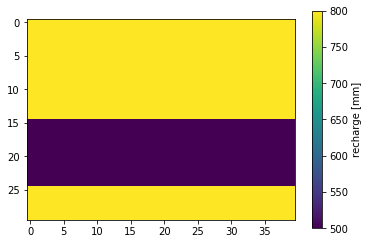

In [7]:
# on va voir ici les deux implémentations d'une recharge, en liste et en array

### array based
# L'array est 2D, de taille (nrow,ncol)
rcha = np.ones([nrow,ncol])* 800 # mm/yr
# on peut alors modifier les valeurs de recharge comme bon nous semble
rcha[15:25,:]=500
plt.imshow(rcha)
g=plt.colorbar()
g.set_label("recharge [mm]")
rcha /= (1000*365*86400) # m/s --> Rappel : toujours avoir les mêmes unités dans le modèle

rcha = fp.mf6.modflow.ModflowGwfrcha(gwf,recharge = rcha,save_flows=True) # notez la présence du "a" à la fin de rch ;)

# les paramètres importants de rcha sont :
# irch : permet de forcer la recharge à s'effectuer à une couche donnée
# fixed cell : empêche la recharge d'être transmise à une celle sous-jacente si la cellule est inactive


### rch list based
# comme avec chd ou wel on doit spécifier la recharge en tout point au format : : lst [(cellid,recharge)]
lst_rch=[]
for irow in range(nrow):
    for icol in range(ncol):
        lst_rch.append(((0,irow,icol),800/(1000*365*86400)))
rch = fp.mf6.modflow.ModflowGwfrch(gwf,stress_period_data=lst_rch,save_flows=True)

# on retire la recharge en liste pour pas avoir double recharges
rch.remove()

#### Remarques :
- La recharge est par défaut appliquée aux cellules de la première couche. Si la cellule est inactive, la recharge est transmise à la cellule sous-jacente.
- Normalement il ne devrait pas y a voir de pertes de recharges avec le mode array mais cela m'est déjà arrivé et dans ces cas là j'utilise le format liste pour être certains que la recharge s'effectue bien aux couches que je souhaite.
**(Vérifiez toujours les flux de recharge entrants s'ils correspondent bien à ceux que vous avez fournis en entrée (fichier LST en sortie de simulation ou analyse de budget)**
- Une recharge appliquée sur une cellule à charge constante est perdue, de même si aucune cellule active n'est rencontrée verticalement
- Le format liste est moins pratique mais plus sûr que le format array

# Limites de type Cauchy

#### On va voir après quelques packages pouvant simuler des limites dites de Cauchy (ou mixtes) car on spécifie à la fois une charge et une pseudo-conductivité (conductance) à la condition limite.

#### Les packages permettant de faire cela de manières simples sont nombreux : RIV, ET, DRN et GHB

## RIV 

#### Le package riv permet de simuler relativement les intéractions d'un aquifère avec une rivière. Dans ce package la rivière est simulée comme un niveau d'eau avec une base (bas de la rivière) et un stage (hauteur d'eau), séparé de la nappe par une couche de sédiments dont la conductance est spécifée par l'utilisateur.

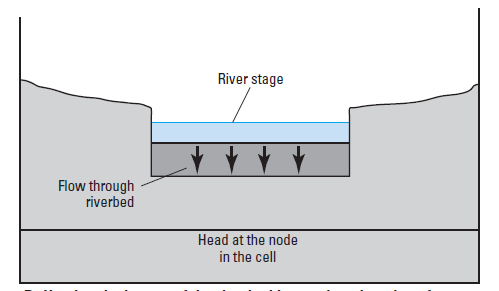

Le calcul du flux entre la rivière et la nappe suit cette courbe :

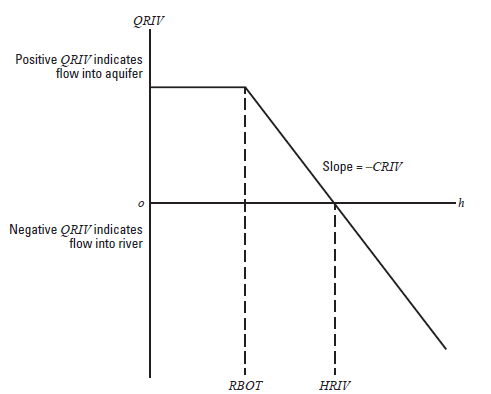

où h représente la charge dans la cellule (nappe), RBOT : le bas de la rivière, CRIV la conductance et HRIV le niveau de la rivière. On voit alors que le flux est dépendant de la charge avec certains paliers comme ici quand la charge passe en dessous de la rivière.

#### La conductance est un paramètre controlant les échanges entre nappe et rivière. Comme on ne spécifie pas la taille de notre rivière lors de l'implémentation, il est alors possible de le faire à l'aide ce paramètre. Il peut s'estimer par la formule suivante :
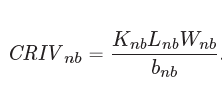
où K est la conductivité, L la longueur de la rivière dans la cellule, W sa largeur et b l'épaisseur de la couche de sédiments

In [8]:
# Implémentation
# mettons une rivière à droite du modèle à une altitude constante de 7 m et un botom de rivière à 5 m

lst_riv=[]
for irow in range(nrow):
    cell = (0,irow,ncol-1)
    lst_riv.append((cell,7,0.01,5)) # format : lst [(cellid,HRIV,conductance,RBOT)]
lst_riv.append((cell,7,0.01,5))

riv = fp.mf6.modflow.ModflowGwfriv(gwf,pname="super_riviere",maxbound=len(lst_riv),stress_period_data={0:lst_riv},save_flows=True)

Remarques : 
- Une cellule avec une condition limite de rivière simule mieux les échanges nappe/rivière en créant une limite "séparée" de la cellule. A la différence de la charge imposée qui occupe toute la cellule.
- 2 cellules peuvent accueillir plusieurs conditions limites de rivière
- Prend plus de temps de calcul
- Plus de paramètres à rentrer et donc à calibrer
- Vérifier que les flux entrant/sortants de la limite ne sont pas aberrants
- Ne simule pas le flux dans la rivière --> voir le package Streamflow Routine

## DRN 

Ce package permet une implémentation rapide et simple de drain, c'est à dire que ce package ne permet que des flux sortants du modèle.

Il s'implèmente en lui spécifiant une altitude et une conductance. 

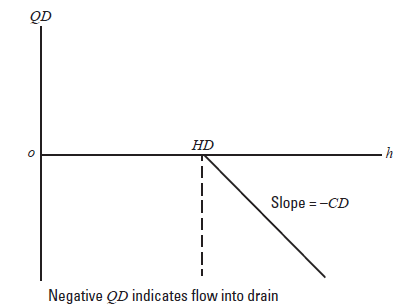
Où HD est l'altitude d'action du drain et CD la conductance


L'implémentation se fait comme pour les autres packages sous forme d'une liste où chaque élément représente un drain avec le cellid, l'altitude du drain et sa conductance.

In [9]:
# Implémentation
# on va mettre une zone drainante à 6 m à la première couche dans le coin inférieur droit du modèle
xd0,xd1,yd0,yd1 = 25,35,20,25

lst_drn=[]
for irow in range(yd0,yd1):
    for icol in range(xd0,xd1):
        cell = (0,irow,icol)
        lst_drn.append((cell,6,0.001)) # format : lst [(cellid,elev,conductance)]
lst_drn.append((cell,6,0.001)) # format : lst [(cellid,elev,conductance)] 

drn = fp.mf6.modflow.ModflowGwfdrn(gwf,pname="drain",maxbound=len(lst_drn),
                                   stress_period_data={0:lst_drn},save_flows=True) # création du pack

Remarques :
- idem que RIV
- La conductance devrait être estimée par des essais réalisés in-situ
- Simule assez fidèlement les zones de débordement d'un aquifère dans une rivière

## EVT 

L'évapotranspiration est un paramètre très complexe à simuler dans les modèles hydrogéologiques et le package EVT de MODFLOW permet une implémentation relativement simple et aisé de ce phénomène. Précision : ce package ne simule que l'ET de la zone saturée (voir le package UZF pour tout ce qui conerne la zone non-saturée).

Ce pack permet l'implémentation de multiples segments dans la courbe d'évaporation en fonction de la charge : 
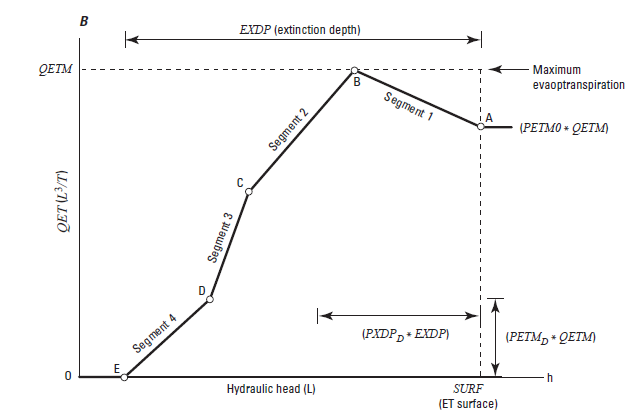
- QETM : flux maximum d'ET
- EXDP : la profondeur d'extinction (la profondeur en dessous de laquelle l'ET n'agit plus)
- PETM : proportion du flux maximum d'ET à la base d'un segment donné
- PETM0 : proportion du flux maximum d'ET lorsque la charge est supérieure à la surface ET (SURF)
- SURF : altitude de l'ET surface
- PXDP  : proportion d'ET de profondeur d'extinction à la base d'un segment donné --> en gros à quelle altitude tu mets tel ou tel segement (mais en proportion de EXDP)

Et d'ainsi dresser la courbe que l'on souhaite en fonction des besoins et connaissances du terrain.

### ! Comme la recharge, le pack ET peut être spécifié en array ou en liste 
(mais je n'arrive pas le faire sous format array)

In [10]:
nseg = 3 # number of segements
rate = 400/1000/86400/365 # maximum ET m/yr

pxdp1 = 0.2
pxdp2 = 0.5
petm0 = 1
petm1 = 0.3
petm2 = 0.1

et_spd=[]
for irow in range(nrow):
    for icol in range(ncol):
        cell = (0,irow,icol)
        surface = top[irow,icol]-0.5 # altitude d'ET max
        depth = surface - 2 # profondeur max d'ET
        et_spd.append((cell,surface,rate,depth,pxdp1,pxdp2,petm1,petm2,petm0))
ET = fp.mf6.modflow.ModflowGwfevt(gwf,nseg=nseg,maxbound=len(et_spd),stress_period_data=et_spd,save_flows=True)

Dans cet exemple je crée un package d'ET avec un total de 3 segments sur une épaisseur de 2 m. Une ET max de 400 mm/an assignée à 0.5 m sous la surface.

J'ai fixé la base de mon premier segement à 0.2 de l'exdp et le 2e à 0.5 (le 3 étant à l'exdp). 

J'ai également fixé une évaporation de 0.3 de la valeur maximale à la base du 1er segement (1 au sommet --> variable petm0) et 0.1 à la base du second (0 au 3e)

Le graphe de l'ET en fonction de la charge hydrau ressemblerait grossièrement à ça (avec une exdp de 5):

Text(0, 0.5, 'ET (mm)')

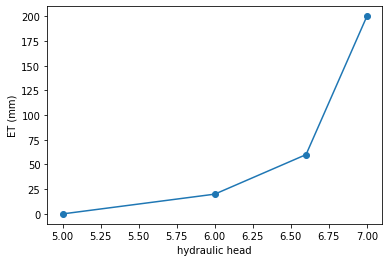

In [11]:
x = np.array([0,0.5,0.8,1])*2+5
y = np.array([0,0.1,0.3,1])*200
plt.plot(x,y,"o-")
plt.xlabel("hydraulic head")
plt.ylabel("ET (mm)")

## GHB

Le package GHB est un package général pour faire des limites de type Cauchy, ainsi seul une altitude et une conductance sont fournies.

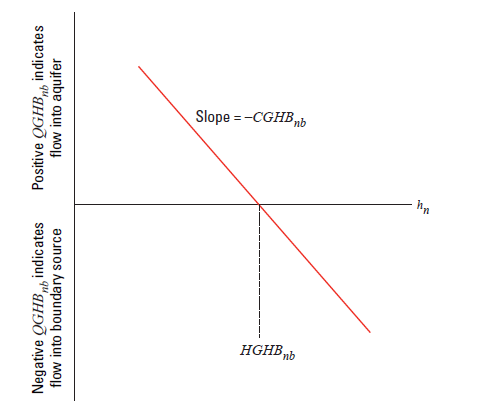

In [12]:
# Implémentation
# mettons une limite GHB sur des points au hasard de notre zone dans la couche 3 (2)
import random
ghb_spd=[]

col_ghb = np.round(ncol*np.random.rand(10))
row_ghb = np.round(nrow*np.random.rand(10))
val_ghb = np.round(5*np.random.rand(10))+5

i=-1
for irow,icol in zip(row_ghb,col_ghb):
    i +=1
    cell=(2,int(irow),int(icol))
    ghb_spd.append((cell,val_ghb[i],0.01))
ghb = fp.mf6.modflow.ModflowGwfghb(gwf,pname="GHABE",stress_period_data=ghb_spd,save_flows=True)

In [13]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model tuto_BC...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd...
    writing package wel...
    writing package rcha...
    writing package super_riviere...
    writing package drain...
    writing package evt...
    writing package ghabe...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 10 based on size of stress_period_data


Exception: The program ../../exe/mf6.exe does not exist or is not executable.

In [ ]:
#récupération des données
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# on initialise une figure
fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(wspace=0.05,hspace=0.1)
# on itère à chaque couche
for layer in range(3):
    ax  = fig.add_subplot(2,2,layer+1, aspect='equal')
    ml = fp.plot.PlotMapView(model=gwf,layer=layer)
    hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
    hmesh.set_clim(0,10)
    
    #spdis
    ml.plot_specific_discharge(spdis[0][0:-1:6],headwidth=5, headlength=6, headaxislength=5)
    
    #plot contour
    cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,10,11),colors="black")
    plt.clabel(cont,fmt="%1i")  
    
    #plot bc 
    ml.plot_bc("wel")
    ml.plot_bc("chd")
    ml.plot_bc("ghb")
    #set labels
    plt.title("layer {}".format(layer))
    plt.colorbar(hmesh)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")

In [ ]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :22})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
x.plot_grid() # plot la grid


#plot_bc
# Quand on plot une condition limite on peut soit se référer au type de bc ou à son pname
x.plot_bc("chd") # plot la condition limite de charge imposée
x.plot_bc("riv") # plot la condition limite riv
x.plot_bc("drain",alpha=0.5) # plot des drains en utilisant le pname défini plus haut
x.plot_bc("GHB")
uiver = x.plot_specific_discharge(spdis, head=head, 
                                       hstep=3, normalize=True, color='green', 
                                       scale=30, headwidth=3, headlength=3, headaxislength=3,
                                       zorder=10)
